<center>
    <h1>Human Value Detection - Pooling Model</h1>
    <h2>Bonini Roberto, Maidana Facundo Nicolas</h2>
    <h3>roberto.bonini@studio.unibo.it, facundo.maidana@studio.unibo.it</h3>
</center>

## Requirements

In [1]:
!nvidia-smi

Sat Apr  8 08:52:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |   4205MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb -qU

In [3]:
!pip install --quiet wandb transformers pytorch-lightning sentencepiece sacremoses "ray[tune]" pytorch-lightning-bolts optuna 

In [4]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [5]:
%cd /content
!rm -r human-value-detection
!git clone  https://github.com/maidacundo/human-value-detection.git
%cd human-value-detection

/content
Cloning into 'human-value-detection'...
remote: Enumerating objects: 727, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 727 (delta 39), reused 46 (delta 22), pack-reused 662
Receiving objects: 100% (727/727), 578.40 KiB | 17.53 MiB/s, done.
Resolving deltas: 100% (438/438), done.
/content/human-value-detection


### Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/human-value-detection')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl

from torchmetrics import Accuracy

from utils import seed
from utils.data import get_processed_df, perform_data_augmentation, HumanValuesDataset, HumanValuesDataModule
from plotting import data_analysis
from models.baseline import TransformerClassifier
from models.pooling_model import TransformerClassifierPooling
from utils.hyperparameters_tuning import HyperparameterTuner

from utils.thresholding import ThresholdModel, SurrogateHeaviside, train_thresholding_model, get_f1_optimized_thresholding, print_classification_report_thresholding

from sklearn.metrics import classification_report, multilabel_confusion_matrix

from IPython.core.display import clear_output

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

from torch.utils.data import DataLoader
from torch import utils

from transformers import MarianMTModel, AutoTokenizer
from pytorch_lightning.loggers import WandbLogger

from functools import partial

import wandb

In [8]:
RANDOM_STATE = 42
seed.fix_random(RANDOM_STATE)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [9]:
device = "cpu"
if torch.cuda.is_available:
  print('Running on GPU')
  device = torch.device("cuda:0")  
else:
  print('Running on CPU, please set GPU.')

Running on GPU


## Data

In [10]:
DATA_ROOT_FOLDER = 'data'

arguments_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-training.tsv', delimiter='\t')
labels_train = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-training.tsv', delimiter='\t')

arguments_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-validation.tsv', delimiter='\t')
labels_val = pd.read_csv(f'{DATA_ROOT_FOLDER}/labels-validation.tsv', delimiter='\t')

arguments_test = pd.read_csv(f'{DATA_ROOT_FOLDER}/arguments-test.tsv', delimiter='\t')

In [11]:
df_train_original = arguments_train.merge(labels_train)
df_test_original = arguments_val.merge(labels_val)

In [12]:
labels_columns = labels_train.drop('Argument ID', axis=1).columns

### Data Augmentation



In [13]:
low_support_columns = []
total_count = labels_train[labels_columns].sum()
for i, count in enumerate(total_count):
    if count<=800:
        low_support_columns.append(total_count.index[i])

high_support_columns = []
total_count = labels_train[labels_columns].sum()
for i, count in enumerate(total_count):
    if count>800:
        high_support_columns.append(total_count.index[i])

In [14]:
df_train_aumentation = df_train_original.loc[
    (df_train_original[low_support_columns] == 1).any(axis=1)
    & (df_train_original[high_support_columns].sum(axis=1) <= 2)
    ]
df_train_aumentation.shape

(1602, 24)

#### MarianMTModel

In [15]:
run_data_augmentation = True #@param {type:"boolean"}

if run_data_augmentation:
    # Get the name of the first model
    first_model_name = 'Helsinki-NLP/opus-mt-en-fr'
    # Get the name of the second model
    second_model_name = 'Helsinki-NLP/opus-mt-fr-en'

    # Get the tokenizer
    first_model_tkn = AutoTokenizer.from_pretrained(first_model_name)
    # Get the tokenizer
    second_model_tkn = AutoTokenizer.from_pretrained(second_model_name)

    # Load the pretrained model based on the name
    first_model = MarianMTModel.from_pretrained(first_model_name)
    # Load the pretrained model based on the name
    second_model = MarianMTModel.from_pretrained(second_model_name)
    clear_output()

    df_train_aumentation = perform_data_augmentation(df_train_aumentation, first_model, second_model, first_model_tkn, second_model_tkn, batch_size=64, columns=['Premise', 'Conclusion'], device=device)
    clear_output()
    torch.cuda.empty_cache()

    df_train_aumentation_original = df_train_aumentation[[*['Argument ID', 'Conclusion', 'Stance', 'Premise'], *labels_columns]]
    df_train_aumentation_augmented = df_train_aumentation[[*['Argument ID', 'Conclusion BT', 'Stance', 'Premise BT'], *labels_columns]]
    df_train_aumentation_augmented.columns = [*['Argument ID', 'Conclusion', 'Stance', 'Premise'], *labels_columns]

    df_train_augmented = df_train_original.append(df_train_aumentation_augmented, ignore_index=True)

    og = df_train_original[labels_columns].sum()
    aug = df_train_augmented[labels_columns].sum()

    conc_sums = pd.concat([og, aug], axis=1)
    conc_sums.columns = ['original', 'augmented']
    conc_sums['percetage augmentation'] = (conc_sums['augmented'] / conc_sums['original']) - 1
 

<ipython-input-15-1b84e473567c>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_augmented = df_train_original.append(df_train_aumentation_augmented, ignore_index=True)


In [16]:
df_train_aumentation_augmented.to_csv('augmented.csv')

In [17]:
conc_sums

,original,augmented,percetage augmentation
Self-direction: thought,988,1169,0.183198
Self-direction: action,1395,1712,0.227240
Stimulation,247,361,0.461538
Hedonism,172,270,0.569767
Achievement,1512,1791,0.184524
Power: dominance,610,877,0.437705
Power: resources,625,949,0.518400
Face,382,560,0.465969
Security: personal,2000,2389,0.194500
Security: societal,1728,1974,0.142361


In [18]:
print(df_train_original.shape)
print(df_train_aumentation.shape)
print(df_train_augmented.shape)

(5393, 24)
(1602, 26)
(6995, 24)


# Models

## all-mpnet-base-v2

In addition to the baseline approach, we propose a
new model architecture that incorporates additional
information from the full output sequence. Specifi-
cally, our model utilizes the final hidden states of
all input tokens, rather than just the first token as
Figure 3: Architecture of the Proposed Transformer
Classifier with Pooling
in the standard approach. This allows our model
to capture more nuanced relationships between the
input sequence and the target label.
Our proposed model was inspired by (Leheˇcka
et al., 2020) architecture, where authors adapt on
top of the BERT transformer a time-distributed
fully connected dense layer to improve the model’s
ability to handle long-range dependencies and per-
form mean and max pooling. We decided to avoid
the usage of LSTM and rely on MPNet, which
combines the strengths of masked and permuted
language modeling for handling the long-range de-
pendencies between words. Our proposed solu-
tion, uses the whole output of transformers (and
not just the [CLS] one), by pooling it using both
max-pooling and mean-pooling. Max-pooling ex-
tracts the strongest class-related features from the
sequence while average-pooling evenly attends to
all tokens in the sequence. All padding tokens were
ignored when computing the pooled values.
The pooled features are then summed together
and normalized, and fed into a final classification
layer as in the baseline. Our proposed model does
not add any trainable parameter.

In [19]:
model_name = 'sentence-transformers/all-mpnet-base-v2'
num_labels = len(labels_columns)

N_EPOCHS = 3
batch_size = 16

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [20]:
train_df = get_processed_df(df_train_original, labels_columns, tokenizer.sep_token)
test_df = get_processed_df(df_test_original, labels_columns, tokenizer.sep_token)
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
print(f'train shape: {train_df.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (4314, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [21]:
train_df_aug = get_processed_df(df_train_aumentation_augmented, labels_columns, tokenizer.sep_token)
train_df_aug = pd.concat([train_df, train_df_aug], ignore_index=True)

print(f'train shape: {train_df_aug.shape}\nval shape: {val_df.shape}\ntest shape: {test_df.shape}')

train shape: (5916, 2)
val shape: (1079, 2)
test shape: (1896, 2)


In [22]:
steps_per_epoch=len(train_df) // batch_size
steps_per_epoch_aug=len(train_df_aug) // batch_size

total_training_steps = steps_per_epoch * N_EPOCHS
total_training_steps_aug = steps_per_epoch_aug * N_EPOCHS

warmup_steps = total_training_steps // N_EPOCHS
warmup_steps_aug = total_training_steps_aug // N_EPOCHS
print('not augmented scheduled steps', (warmup_steps, total_training_steps))
print('augmented scheduled steps', (warmup_steps_aug, total_training_steps_aug))

not augmented scheduled steps (269, 807)
augmented scheduled steps (369, 1107)


In [23]:
data_module = HumanValuesDataModule(train_df, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module.setup()

data_module_aug = HumanValuesDataModule(train_df_aug, val_df, test_df, tokenizer, batch_size=batch_size, max_token_len=128)
data_module_aug.setup()

### Hyperparameters Tuning

In [ ]:
partial_model = partial(TransformerClassifierPooling, model_name, num_labels, n_training_steps=total_training_steps, n_warmup_steps=warmup_steps, num_lstm_layers=2)

study_params = {
    "n_epochs": 3,
    "n_trials": 2,
    "lim_train_batches": 0.2,
    "lim_val_batches": 0.4,
    "lr_transformer": [5e-5],
    "lr_classifier": [1e-3],
    "weight_decay": [1e-3],
    "classifier_dropout": [.2, .3],
}
tuner = HyperparameterTuner(data_module, partial_model, study_params)

In [ ]:
tune = False
if tune:
    tuner.run_study()

In [ ]:
tuned_hyperparameters = tuner.get_best_hyperparams()

In [ ]:
tuned_hyperparameters

{'lr_transformer': 5e-05,
 'lr_classifier': 0.001,
 'weight_decay': 0.001,
 'classifier_dropout': 0.1}

In [24]:
pooling_model_aug = TransformerClassifierPooling(model_name, 
                                                 num_labels, 
                                                 classifier_dropout=0.1, 
                                                 optimizer=torch.optim.AdamW, 
                                                 lr_transformer=5e-05, 
                                                 lr_classifier=1e-2,
                                                 weight_decay=1e-4,
                                                 n_training_steps=total_training_steps_aug, 
                                                 n_warmup_steps=warmup_steps_aug,
                                                 ) 

### Training

In [25]:
!rm -rf lightning_logs/
!rm -rf checkpoints/
     
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/baseline

clear_output()

In [26]:
# e9ec24521d2c9a845865b5e4d6be07386c8843aa
wandb.login(key='e9ec24521d2c9a845865b5e4d6be07386c8843aa')

wandb: Currently logged in as: nlp-project-unibo (human-value-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=1, min_delta=.002)
lr_monitor = LearningRateMonitor(logging_interval='step')
tensorboard_logger = pl.loggers.TensorBoardLogger("lightning_logs", name="human-values")

try:
    wandb.finish()
except:
    pass
wandb_logger = WandbLogger(project="human-value-final", name='pooling_mpnet_base_aug')

trainer = pl.Trainer(
  logger=[tensorboard_logger, wandb_logger],
  callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
  max_epochs=N_EPOCHS,
  accelerator='gpu'
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [30]:
# log gradients, parameter histogram and model topology
wandb_logger.watch(pooling_model_aug, log="all")
trainer.fit(pooling_model_aug, data_module_aug)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | MPNetModel        | 109 M 
1 | dropout    | Dropout           | 0     
2 | classifier | Linear            | 15.4 K
3 | loss_fn    | BCEWithLogitsLoss | 0     
4 | metrics    | ModuleDict        | 0     
-------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.007   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 370: 'val_loss' reached 0.32562 (best 0.32562), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 740: 'val_loss' reached 0.29953 (best 0.29953), saving model to '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1110: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [31]:
!cp -f '/content/human-value-detection/checkpoints/best-checkpoint.ckpt' '/content/drive/MyDrive/human-value-detection/models/pooling-mpnet-aug.ckpt'

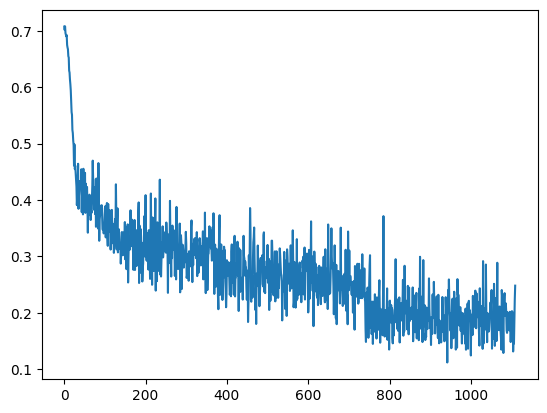

In [32]:
plt.plot([i.cpu().item() for i in pooling_model_aug.losses])

### Predictions

In [33]:
trained_model = TransformerClassifierPooling.load_from_checkpoint(
  "/content/drive/MyDrive/human-value-detection/models/pooling-mpnet-aug.ckpt",
  **{'model_name':model_name, 
     'num_labels':num_labels, 
     'classifier_dropout':.1, 
     'optimizer':torch.optim.AdamW,
     'lr_transformer':5e-05, 
     'lr_classifier':1e-5,
     'weight_decay':1e-4,
     'n_training_steps':total_training_steps, 
     'n_warmup_steps':warmup_steps,
     },
)

In [34]:
trained_model.eval()
trained_model.freeze()

In [35]:
predictions_train = trainer.predict(trained_model, data_module.threshold_train_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [36]:
pred_labels_train = np.array([pred.cpu().numpy() for preds in predictions_train for pred in preds])
true_labels_train = np.array([i for i in train_df['labels']])

In [37]:
predictions_test = trainer.predict(trained_model, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [38]:
pred_labels_test = np.array([pred.cpu().numpy() for preds in predictions_test for pred in preds])
true_labels_test = np.array([i for i in test_df['labels']])

#### Threshold Optimization

https://arxiv.org/pdf/2103.00833.pdf

https://github.com/topel/sglthresh/blob/master/sgl_emotions.ipynb

In [39]:
MANUAL_THRESHOLD = .5

In [40]:
f1_score_optimized_thresholds = get_f1_optimized_thresholding(true_labels_train, pred_labels_train, labels_columns)
print(f'optimized_thresholds: \n{f1_score_optimized_thresholds}')

optimized_thresholds: 
[0.55, 0.6, 0.6, 0.65, 0.55, 0.5, 0.65, 0.35, 0.55, 0.5, 0.65, 0.3, 0.4, 0.45, 0.35, 0.45, 0.55, 0.35, 0.4, 0.45]


--------------------
learned_thresholds: 
[0.42664343 0.47414455 0.48232612 0.5699347  0.39032543 0.36807042
 0.57102317 0.31924483 0.34172106 0.32145485 0.40489286 0.20474634
 0.36786604 0.3153822  0.21005382 0.39947045 0.37412435 0.21773379
 0.3175352  0.3667291 ]


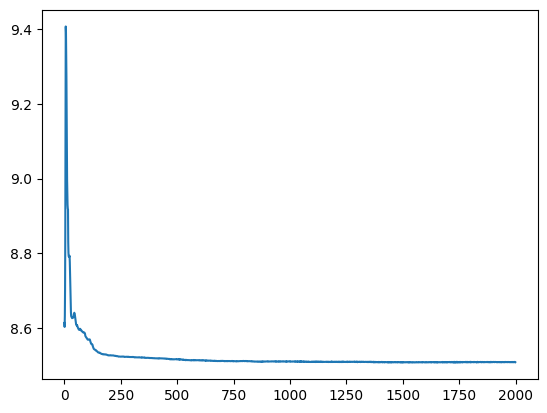

In [56]:
threshold_fn = SurrogateHeaviside.apply
model = ThresholdModel(threshold_fn=threshold_fn, device=device, t=.5, sigma=1., num_labels=num_labels, use_dense=False)
criterion = torch.nn.CrossEntropyLoss()

train_thresholding_model(model=model, 
                         predictions=pred_labels_train,
                         labels=true_labels_train,
                         epochs=2000, 
                         criterion=criterion, 
                         num_labels=num_labels,
                         lr=1e-01,
                         verbose=False
                         )
learned_thresholds=model.thresh.clone().detach().cpu().numpy()
sigma = model.sigma.clone().detach().cpu().numpy()
print(f'learned_thresholds: \n{learned_thresholds}')

#### Train

In [42]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=0.25)

                            precision    recall  f1-score   support

   Self-direction: thought       0.56      0.95      0.70       804
    Self-direction: action       0.49      0.95      0.65      1134
               Stimulation       0.31      0.77      0.44       196
                  Hedonism       0.39      0.91      0.55       137
               Achievement       0.59      0.94      0.72      1212
          Power: dominance       0.42      0.80      0.56       482
          Power: resources       0.47      0.98      0.64       496
                      Face       0.43      0.66      0.52       304
        Security: personal       0.67      0.94      0.78      1594
        Security: societal       0.65      0.95      0.77      1383
                 Tradition       0.55      0.94      0.69       454
         Conformity: rules       0.62      0.79      0.70       928
 Conformity: interpersonal       0.56      0.79      0.65       172
                  Humility       0.52      0.80

In [43]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.77      0.84      0.81       804
    Self-direction: action       0.81      0.79      0.80      1134
               Stimulation       0.65      0.52      0.58       196
                  Hedonism       0.70      0.73      0.72       137
               Achievement       0.81      0.81      0.81      1212
          Power: dominance       0.70      0.59      0.64       482
          Power: resources       0.72      0.87      0.79       496
                      Face       0.57      0.55      0.56       304
        Security: personal       0.86      0.82      0.84      1594
        Security: societal       0.84      0.82      0.83      1383
                 Tradition       0.84      0.75      0.80       454
         Conformity: rules       0.66      0.75      0.70       928
 Conformity: interpersonal       0.70      0.73      0.71       172
                  Humility       0.75      0.63

In [44]:
print_classification_report_thresholding(true_labels_train, pred_labels_train, labels_columns, threshold=learned_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.71      0.88      0.78       804
    Self-direction: action       0.69      0.87      0.77      1134
               Stimulation       0.60      0.55      0.57       196
                  Hedonism       0.66      0.76      0.71       137
               Achievement       0.71      0.87      0.78      1212
          Power: dominance       0.61      0.65      0.63       482
          Power: resources       0.65      0.90      0.75       496
                      Face       0.60      0.51      0.55       304
        Security: personal       0.74      0.91      0.82      1594
        Security: societal       0.73      0.91      0.81      1383
                 Tradition       0.74      0.84      0.79       454
         Conformity: rules       0.63      0.78      0.70       928
 Conformity: interpersonal       0.76      0.65      0.70       172
                  Humility       0.71      0.66

#### Test


In [57]:
print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=0.25)

                            precision    recall  f1-score   support

   Self-direction: thought       0.33      0.78      0.47       251
    Self-direction: action       0.37      0.86      0.52       496
               Stimulation       0.29      0.39      0.33       138
                  Hedonism       0.35      0.58      0.43       103
               Achievement       0.48      0.87      0.62       575
          Power: dominance       0.25      0.48      0.33       164
          Power: resources       0.32      0.89      0.47       132
                      Face       0.31      0.38      0.34       130
        Security: personal       0.60      0.91      0.73       759
        Security: societal       0.47      0.81      0.60       488
                 Tradition       0.35      0.54      0.43       172
         Conformity: rules       0.51      0.69      0.59       455
 Conformity: interpersonal       0.37      0.38      0.38        60
                  Humility       0.17      0.25

In [58]:
print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=f1_score_optimized_thresholds)

                            precision    recall  f1-score   support

   Self-direction: thought       0.48      0.51      0.50       251
    Self-direction: action       0.63      0.58      0.61       496
               Stimulation       0.49      0.14      0.22       138
                  Hedonism       0.59      0.40      0.47       103
               Achievement       0.64      0.66      0.65       575
          Power: dominance       0.43      0.23      0.30       164
          Power: resources       0.44      0.58      0.50       132
                      Face       0.38      0.23      0.29       130
        Security: personal       0.77      0.78      0.78       759
        Security: societal       0.62      0.56      0.59       488
                 Tradition       0.61      0.39      0.48       172
         Conformity: rules       0.53      0.65      0.58       455
 Conformity: interpersonal       0.50      0.25      0.33        60
                  Humility       0.26      0.13

In [59]:
pooling_aug_report = print_classification_report_thresholding(true_labels_test, pred_labels_test, labels_columns, threshold=learned_thresholds, output_dict=True)

                            precision    recall  f1-score   support

   Self-direction: thought       0.44      0.67      0.53       251
    Self-direction: action       0.52      0.68      0.59       496
               Stimulation       0.40      0.20      0.27       138
                  Hedonism       0.53      0.43      0.47       103
               Achievement       0.55      0.77      0.64       575
          Power: dominance       0.34      0.35      0.35       164
          Power: resources       0.41      0.64      0.50       132
                      Face       0.36      0.27      0.31       130
        Security: personal       0.66      0.88      0.76       759
        Security: societal       0.51      0.73      0.60       488
                 Tradition       0.47      0.50      0.48       172
         Conformity: rules       0.48      0.73      0.58       455
 Conformity: interpersonal       0.55      0.30      0.39        60
                  Humility       0.17      0.18

# Error Analysis


In [60]:
pooling_reports = [pooling_aug_report]

In [61]:
import pickle
with open('/content/human-value-detection/baseling_bert_base_reports.pkl', 'rb') as f:
    baseling_bert_base_reports = pickle.load(f)

with open('/content/human-value-detection/baseling_mpnet_base_reports.pkl', 'rb') as f:
    baseling_mpnet_base_reports = pickle.load(f)

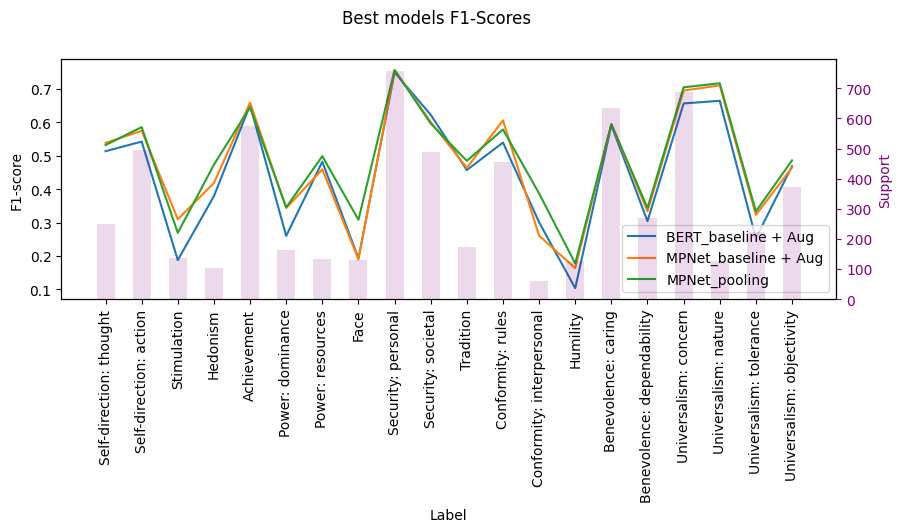

In [63]:
from plotting.data_analysis import plot_classification_reports

reports = [baseling_bert_base_reports[1], baseling_mpnet_base_reports[1], pooling_reports[0]]
reports_names = ['BERT_baseline + Aug', 'MPNet_baseline + Aug', 'MPNet_pooling + Aug']

plot_classification_reports(reports, reports_names, 'Best models F1-Scores')